# Clustering

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Caricamento del dataset
df = pd.read_csv('Datasets/atp_tennis.csv')

# Pre-elaborazione
# Rimuovere righe con valori mancanti (se presenti)
df = df.dropna()

Prima di eseguire il clustering, dobbiamo raccogliere le feature dai dati delle partite di tennis, seguendo i seguenti passaggi:

1.	Durata della partita:

    Anche se il tuo dataset non include un campo che indichi la durata della partita, possiamo calcolare una metrica equivalente. Possiamo utilizzare il numero di set giocati o la differenza nei punteggi come indicatore della durata della partita.

2.	Numero di partite giocate (total_games_played):

    Calcoliamo il numero di partite giocate per ogni giocatore. Questo si può ottenere contando il numero di righe in cui il giocatore compare come Player_1 o Player_2 nel dataset.

3.	Punteggi totali (total_points):

    Sommiamo i punteggi di un giocatore da ogni partita. Per esempio, possiamo sommare Pts_1 per il giocatore Player_1 e Pts_2 per Player_2 per ottenere un totale di punti per ogni giocatore.

4.	Numero di tornei a cui un giocatore ha partecipato (n_tournaments):

    Questo può essere calcolato contando i tornei distinti a cui un giocatore ha partecipato. Ad esempio, possiamo ottenere il numero di tornei unici tramite il campo Tournament.

5.	Numero di finali giocate (total_final_matches):

    Per calcolare questo, possiamo filtrare le partite in cui un giocatore ha partecipato alla finale (questo potrebbe richiedere una colonna aggiuntiva per identificare la fase del torneo).

6.	Numero di vittorie (total_wins):

    Il numero di vittorie totali di un giocatore può essere calcolato contando il numero di volte che un giocatore appare come Winner nel dataset.

7.	Superficie di gioco (surface):

    Può essere utile come feature categorica, come nel caso dei calciatori con le superfici di gioco (Hard, Grass, Clay), che può influire sul gioco di un tennista.

In [35]:
# 1. Calcolare il numero di partite giocate per ogni giocatore
total_games_player_1 = df.groupby('Player_1').size()
total_games_player_2 = df.groupby('Player_2').size()

# Uniamo i due gruppi per ottenere il numero totale di partite giocate per ogni giocatore
total_games = total_games_player_1.add(total_games_player_2, fill_value=0)

# 2. Calcolare i punteggi totali per ogni giocatore
#total_points_player_1 = df.groupby('Player_1')['Pts_1'].sum()
#total_points_player_2 = df.groupby('Player_2')['Pts_2'].sum()

# Sommiamo i punteggi per ottenere il totale di punti
#total_points = total_points_player_1.add(total_points_player_2, fill_value=0)

# 3. Numero di tornei a cui ogni giocatore ha partecipato (contiamo i tornei unici)
n_tournaments_player_1 = df.groupby('Player_1')['Tournament'].nunique()
n_tournaments_player_2 = df.groupby('Player_2')['Tournament'].nunique()

# Uniamo i due gruppi per ottenere il numero totale di tornei a cui ogni giocatore ha partecipato
n_tournaments = n_tournaments_player_1.add(n_tournaments_player_2, fill_value=0)

# 4. Calcolare il numero di Quarterfinals giocate per ogni tennista
quarterfinals_played_player_1 = df[df['Round'] == 'Quarterfinals'].groupby('Player_1').size()
quarterfinals_played_player_2 = df[df['Round'] == 'Quarterfinals'].groupby('Player_2').size()

# Uniamo i due gruppi per ottenere il numero totale di Quarterfinals giocate per ogni giocatore
quarterfinals_played = quarterfinals_played_player_1.add(quarterfinals_played_player_2, fill_value=0)

# Calcolare il numero di Semifinals giocate per ogni tennista
semifinals_played_player_1 = df[df['Round'] == 'Semifinals'].groupby('Player_1').size()
semifinals_played_player_2 = df[df['Round'] == 'Semifinals'].groupby('Player_2').size()

# Uniamo i due gruppi per ottenere il numero totale di Semifinals giocate per ogni giocatore
semifinals_played = semifinals_played_player_1.add(semifinals_played_player_2, fill_value=0)

# Calcolare il numero di Finali giocate per ogni tennista
finals_played_player_1 = df[df['Round'] == 'The Final'].groupby('Player_1').size()
finals_played_player_2 = df[df['Round'] == 'The Final'].groupby('Player_2').size()

# Uniamo i due gruppi per ottenere il numero totale di Finali giocate per ogni giocatore
finals_played = finals_played_player_1.add(finals_played_player_2, fill_value=0)

# 5. Numero di vittorie (ogni volta che un giocatore appare come Winner)
total_wins = df.groupby('Winner').size()

# 6. Otteniamo il miglior rank per ciascun giocatore (ovvero il rank minimo)
rank_max_player_1 = df.groupby('Player_1')['Rank_1'].min()
rank_max_player_2 = df.groupby('Player_2')['Rank_2'].min()
rank_max = rank_max_player_1.combine_first(rank_max_player_2)

# Creiamo un DataFrame con tutte le feature calcolate
clustering_data = pd.DataFrame({
    'total_games': total_games,
    'n_tournaments': n_tournaments,
    'quarterfinals_played': quarterfinals_played,
    'semifinals_played': semifinals_played,
    'finals_played': finals_played,
    'total_wins': total_wins,
    'rank_max': rank_max
})

# 7. Gestire i valori NaN e Inf
clustering_data = clustering_data.fillna(0)  # Sostituire NaN con 0
clustering_data = clustering_data.replace([np.inf, -np.inf], 0)  # Sostituire Inf con 0

# 8. Convertire tutte le colonne in interi
clustering_data = clustering_data.astype(int)

# Verifica dei dati
# Ordinare il DataFrame in base al numero di vittorie (total_wins) in ordine decrescente
clustering_data_sorted = clustering_data.sort_values(by='total_wins', ascending=False)

# Stampare il DataFrame ordinato
print(clustering_data_sorted)

                 total_games  n_tournaments  quarterfinals_played  \
Federer R.              1393            125                   227   
Djokovic N.             1211            100                   193   
Nadal R.                1214            123                   209   
Ferrer D.               1035            172                   156   
Murray A.                924            138                   132   
...                      ...            ...                   ...   
Holmgren A.                1              1                     0   
Hocevar R.                 5              5                     0   
Riffice S.                 1              1                     0   
Rincon D.                  3              2                     0   
van der Meer N.            1              1                     0   

                 semifinals_played  finals_played  total_wins  rank_max  
Federer R.                     199            153        1151         1  
Djokovic N.            

Filtriamo i tennisti che hanno vinto almeno una volta in carriera

In [37]:
# Filtrare i tennisti che hanno vinto almeno una volta in carriera

print(clustering_data[clustering_data['total_wins'] > 0].sort_values(by='total_wins', ascending=False))

              total_games  n_tournaments  quarterfinals_played  \
Federer R.           1393            125                   227   
Djokovic N.          1211            100                   193   
Nadal R.             1214            123                   209   
Ferrer D.            1035            172                   156   
Murray A.             924            138                   132   
...                   ...            ...                   ...   
Fraile G.               9              8                     0   
Friedl L.               5              5                     0   
Froberg J.              2              1                     0   
Rieschick S.            4              4                     0   
 Hajek J.               2              1                     0   

              semifinals_played  finals_played  total_wins  rank_max  
Federer R.                  199            153        1151         1  
Djokovic N.                 176            136        1020       

La matrice di correlazione è uno strumento molto utile per capire come le variabili del tuo dataset siano collegate tra loro. Essa mostra quanto due variabili siano correlate tra loro: se il valore della correlazione è vicino a 1, significa che c’è una forte correlazione positiva, se è vicino a -1, c’è una forte correlazione negativa, mentre un valore vicino a 0 indica che non c’è correlazione.

Passaggi per calcolare e visualizzare la matrice di correlazione:

1.	Calcolare la matrice di correlazione: Usiamo la funzione .corr() di Pandas, che calcola la correlazione tra le variabili numeriche nel DataFrame.
    
2.	Visualizzare la matrice di correlazione: Usiamo una heatmap per visualizzare la matrice, che rende più facile interpretare i valori di correlazione.

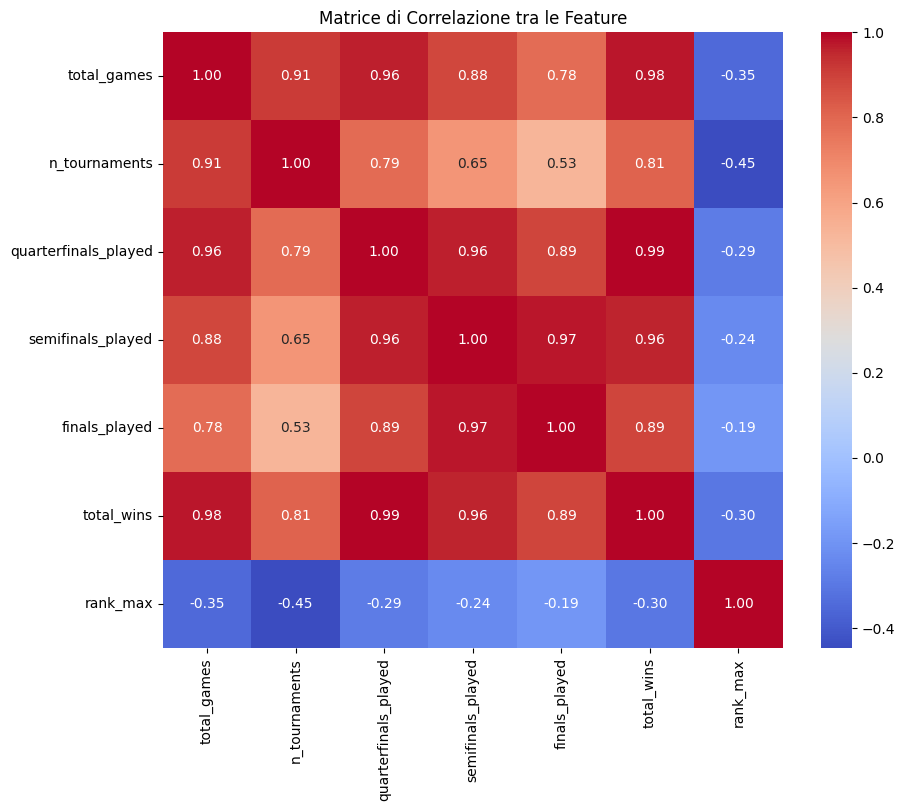

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcolare la matrice di correlazione per il DataFrame (solo le colonne numeriche)
correlation_matrix = clustering_data.corr()

# Visualizzare la matrice di correlazione come una heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Matrice di Correlazione tra le Feature')
plt.show()

La PCA (Principal Component Analysis) è una tecnica di riduzione della dimensionalità che consente di ridurre il numero di variabili, mantenendo la maggior parte dell’informazione (varianza) del dataset originale. PCA trova delle combinazioni lineari delle variabili originali chiamate componenti principali che spiegano la maggior parte della varianza nel dataset.

Quando hai un dataset con molte feature correlate, come nel tuo caso, la PCA ti permette di ridurre il numero di variabili senza perdere informazioni cruciali, migliorando l’efficienza computazionale e la comprensibilità del modello.

Passaggi per applicare PCA:

1.	Preparare i dati: È importante normalizzare i dati prima di applicare la PCA, poiché PCA è sensibile alla scala delle variabili.

2.	Applicare PCA: Usare PCA di Scikit-learn per ridurre il numero di componenti.

3.	Scegliere il numero di componenti: Decidere quante componenti principali mantenere. Generalmente si mantiene abbastanza componenti per spiegare una percentuale significativa della varianza (ad esempio, l’80% della varianza).

Codice per applicare la PCA:

1.	Normalizzazione dei Dati: Prima di applicare PCA, bisogna normalizzare i dati (ridurre i valori a una scala comune).

2.	Applicazione della PCA: Dopo aver normalizzato i dati, possiamo applicare la PCA e ridurre il numero di componenti.

Varianza spiegata da ogni componente principale: [0.80215267 0.15377619]
               total_games  n_tournaments  quarterfinals_played  \
 Hajek J.              2.0            1.0                   0.0   
Abdulla M.             1.0            1.0                   0.0   
Abel M.                8.0            8.0                   0.0   
Acasuso J.           340.0          109.0                  37.0   
Adaktusson J.          1.0            1.0                   0.0   

               semifinals_played  finals_played  total_wins  rank_max  PC1  \
 Hajek J.                    0.0            0.0         1.0      79.0  NaN   
Abdulla M.                   0.0            0.0         0.0    1349.0  NaN   
Abel M.                      0.0            0.0         1.0     191.0  NaN   
Acasuso J.                  23.0           11.0       175.0      20.0  NaN   
Adaktusson J.                0.0            0.0         0.0     265.0  NaN   

               PC2  
 Hajek J.      NaN  
Abdulla M.   

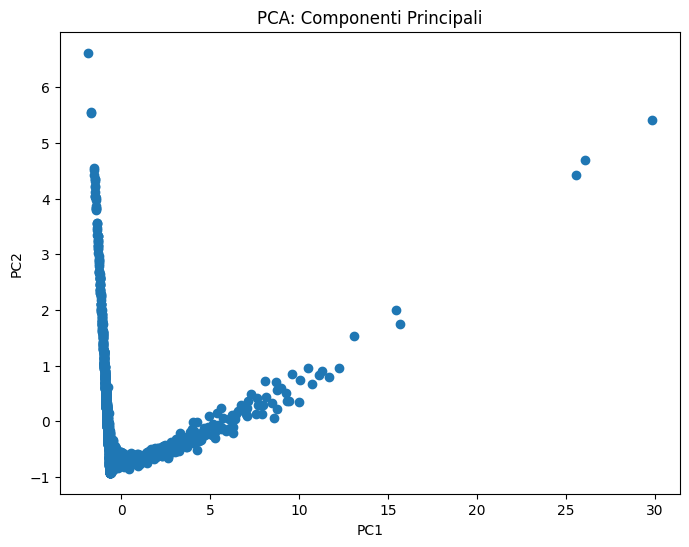

In [39]:
# Supponiamo che clustering_data contenga le variabili numeriche di interesse
# Seleziona solo le colonne numeriche per la PCA
numeric_data = clustering_data[['total_games', 'total_wins', 'rank_max', 'finals_played', 'quarterfinals_played', 'semifinals_played']]

# 1. Normalizzare i dati
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# 2. Applicare PCA
pca = PCA(n_components=2)  # Scegli il numero di componenti principali da mantenere
pca_components = pca.fit_transform(scaled_data)

# 3. Visualizzare la varianza spiegata da ogni componente principale
print(f"Varianza spiegata da ogni componente principale: {pca.explained_variance_ratio_}")

# Creiamo un DataFrame con le componenti principali
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])

# Aggiungiamo le componenti principali al DataFrame originale
clustering_data_with_pca = pd.concat([clustering_data, pca_df], axis=1)

# Visualizza il DataFrame con le componenti principali
print(clustering_data_with_pca.head())

# (Facoltativo) Visualizzare le componenti principali
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.title('PCA: Componenti Principali')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()